In [1]:
import os
import tensorflow as tf
os.chdir('../')

In [2]:
from firstClassifier.constants import *
from firstClassifier.utils.common import read_yaml, create_directories

In [3]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class PrepareCallbacksConfig:
  root_dir: Path
  tensorboard_root_log_dir: Path
  checkpoint_model_filepath: Path

In [4]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class TrainingConfig:
  root_dir: Path
  trained_model_path: Path
  updated_base_model_path: Path
  training_data: Path
  params_epochs: int
  params_batch_size: int
  params_is_augmentation: bool
  params_image_size: list
  

In [5]:
class ConfigurationManager:

    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath= PARAMS_FILE_PATH
             ):
        """_summary_: Creates artifact directories taken from config.yaml file
        """
        self.config= read_yaml(config_filepath)
        self.params= read_yaml(params_filepath)
        ##Create directories
        create_directories([self.config.artifacts_root])

    def get_prepare_callback_config(self)->PrepareCallbacksConfig:
        """Preparing callback configs

        Returns:
            PreapareCallbackConfig: PreapareCallbackConfig
        """
        ##Config contains the attributes that are present in prepare_base_model in config.yaml
        
        config= self.config.prepare_callbacks
        model_ckpt_dir= os.path.dirname(config.checkpoint_model_filepath)
        ##Create directory for checkpoint, tensorboard root log
        create_directories([Path(model_ckpt_dir),
                            Path(config.tensorboard_root_log_dir)
                            ])

        prepare_callback_config= PrepareCallbacksConfig(   
                root_dir= config.root_dir,
                tensorboard_root_log_dir= config.tensorboard_root_log_dir,
                checkpoint_model_filepath= config.checkpoint_model_filepath

            )
        return prepare_callback_config
    
    def get_training_config(self)->TrainingConfig:
        training= self.config.training
        training_data= os.path.join(self.config.data_ingestion.unzip_dir, "PetImages")
        create_directories([
            Path(training.root_dir)
        ])

        training_config= TrainingConfig(
            root_dir= Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_base_model_path= self.config.prepare_base_model.updated_base_model_path,
            training_data= Path(training_data),
            params_epochs= self.params.EPOCHS,
            params_batch_size= self.params.BATCH_SIZE,
            params_is_augmentation= self.params.AUGMENTATION,
            params_image_size= self.params.IMAGE_SIZE
        )

        return training_config

In [6]:
import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf
import time
class PrepareCallback:
    """Get the base model and update the parameters with dataset.
    Picking up Defined architectures in Tensorflow and updating with dataset available
    """
    def __init__(self, config: PrepareCallbacksConfig):
        self.config= config

    @property
    def _create_tb_callbacks(self):
        timestamp= time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir= os.path.join(
            self.config.tensorboard_root_log_dir, 
            f"tb_logs_at_{timestamp}"
        )
        return tf.keras.callbacks.TensorBoard(log_dir= tb_running_log_dir)
    
    @property
    def _create_ckpt_callbacks(self):
        return tf.keras.callbacks.ModelCheckpoint(
            filepath=self.config.checkpoint_model_filepath,
            save_best_only=True
        )
    
    def get_tb_ckpt_callbacks(self):
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks
        ]
    

In [14]:
import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf
import time
class Training:
    def __init__(self, config: TrainingConfig):
        self.config= config

    def get_base_model(self):
        self.model= tf.keras.models.load_model(
            self.config.updated_base_model_path
        )
    
    def train_valid_generator(self):

        ##Augmentation
        datagenerator_kwargs= dict(
            rescale= 1./255,
            validation_split= 0.20

        )

        dataflow_kwargs= dict(
            target_size= self.config.params_image_size[:-1],
            batch_size= self.config.params_batch_size,
            interpolation= "bilinear"
        )

        valid_datagenerator= tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator= valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle= False,
            **dataflow_kwargs
        )

        if self.config.params_is_augmentation:
            train_datagenerator= tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=40,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                **datagenerator_kwargs
            )
            
        else:
            train_datagenerator= valid_datagenerator

        self.train_generator= train_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="training",
            shuffle= True,
            **dataflow_kwargs
        )
    @staticmethod
    def save_model(path:Path, model: tf.keras.Model):
        model.save(path)

        
    def train(self, callback_list):

        self.steps_per_epoch= self.train_generator.samples// self.train_generator.batch_size
        self.validation_steps= self.valid_generator.samples // self.valid_generator.batch_size

        self.model.fit(
            self.train_generator,
            epochs= self.config.params_epochs,
            steps_per_epoch= self.steps_per_epoch,
            validation_steps= self.validation_steps,
            validation_data= self.valid_generator,
            callbacks= callback_list
        )

        self.save_model(
            path= self.config.trained_model_path,
            model= self.model
        )

In [15]:
try:
    config= ConfigurationManager()
    prepare_callbacks_config= config.get_prepare_callback_config()
    prepare_callbacks= PrepareCallback(config= prepare_callbacks_config)
    callback_list= prepare_callbacks.get_tb_ckpt_callbacks()

    training_config= config.get_training_config()
    training= Training(config= training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train(
        callback_list=callback_list
    )

except Exception as e:
    raise e

[2023-04-03 21:45:45,047: INFO: common]: yaml file: configs/config.yaml loaded successfully
[2023-04-03 21:45:45,052: INFO: common]: yaml file: params.yaml loaded successfully
[2023-04-03 21:45:45,054: INFO: common]: created directory at: artifacts
[2023-04-03 21:45:45,056: INFO: common]: created directory at: artifacts/prepare_callbacks/checkpoint_dir
[2023-04-03 21:45:45,061: INFO: common]: created directory at: artifacts/prepare_callbacks/tensorboard_log_dir
[2023-04-03 21:45:45,066: INFO: common]: created directory at: artifacts/training
Found 4998 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
  40/1250 [..............................] - ETA: 1:02:59 - loss: 14.5994 - accuracy: 0.5391

KeyboardInterrupt: 

In [1]:
import os
os.chdir("../")
import tensorflow as tf

In [2]:
os.getcwd()

'/Users/vikaslakka/Desktop/FSDS/DeepLearning/Projects/CNN_projects/First_classifier'

In [3]:
model= tf.keras.models.load_model("artifacts/training/model.h5")

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [62]:
from PIL import Image
img= Image.open("artifacts/data_ingestion/PetImages/Dog/215.jpg")

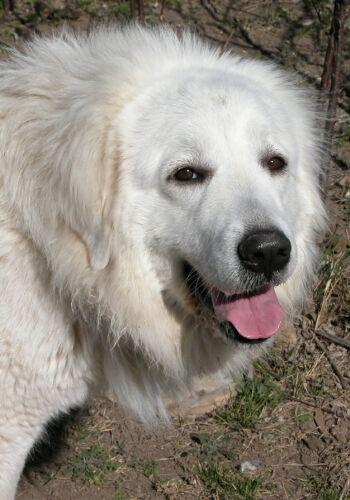

In [63]:
img

In [64]:
import numpy as np


In [65]:
img_array= np.array(img)

In [66]:
img_array.shape

(500, 350, 3)

In [67]:
image_array_resize= tf.image.resize(img_array,[224,224])

In [68]:
np.expand_dims(image_array_resize, axis=0).shape

(1, 224, 224, 3)

In [69]:
image_array_reshape= np.expand_dims(image_array_resize, axis=0)

In [70]:
result= model.predict(image_array_reshape).argmax(axis=1)

1/1 [==============================] - 0s 182ms/step


In [71]:
if result[0]==0:
    print("predicted: Cat")
else:
    print("PRedicted: Dog")
    

PRedicted: Dog


In [77]:
model.predict(image_array_reshape).argmax(axis=1)

1/1 [==============================] - 0s 192ms/step


array([1])